In [1]:
import numpy as np
import pandas as pd

from os import path
import re

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker

import missingno as mn

In [2]:
pd.reset_option('display.float_format')

my_cmap = ListedColormap(sns.color_palette().as_hex())

### Import Data

First, we will import all of our datasets into a single dictionary for convenience:

In [3]:
fd = ['..','data','raw']

data = {}
fn_list = ['orders.csv', 'products.csv', 'order_products__prior.csv', 'order_products__train.csv', 'departments.csv', 'aisles.csv']

for fn in fn_list:
    fp = path.join(*fd, fn)

    with open(file=fp, mode='r', encoding='utf8') as file:
        import re
        label = re.sub('\.csv$', '', fn)
        data[label] = pd.read_csv(file, encoding='utf8')

Checking the size of each dataset:

In [4]:
for k,v in data.items():
    print('{}: {} rows, {} columns; {} null values'.format(k, v.shape[0], v.shape[1], v.isnull().sum().sum()))

orders: 3421083 rows, 7 columns; 206209 null values
products: 49688 rows, 4 columns; 0 null values
order_products__prior: 32434489 rows, 4 columns; 0 null values
order_products__train: 1384617 rows, 4 columns; 0 null values
departments: 21 rows, 2 columns; 0 null values
aisles: 134 rows, 2 columns; 0 null values


High volume of data on the mangitude of millions for the order/product tables. Prior data has 32 million records, which may pose problems for performance during evaluation. Worth considering methods of reducing the dimensionality.

### Null Data

Will check to see why we are missing values in the orders table:

In [12]:
data['orders'].isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [14]:
data['orders'].head(20)

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0    2539329        1    prior             1          2                  8   
1    2398795        1    prior             2          3                  7   
2     473747        1    prior             3          3                 12   
3    2254736        1    prior             4          4                  7   
4     431534        1    prior             5          4                 15   
5    3367565        1    prior             6          2                  7   
6     550135        1    prior             7          1                  9   
7    3108588        1    prior             8          1                 14   
8    2295261        1    prior             9          1                 16   
9    2550362        1    prior            10          4                  8   
10   1187899        1    train            11          4                  8   
11   2168274        2    prior             1          2                 11   
12   1501582        2    prior             2          5                 10   
13   1901567        2    prior             3          1                 10   
14    738281        2    prior             4          2                 10   
15   1673511        2    prior             5          3                 11   
16   1199898        2    prior             6          2                  9   
17   3194192        2    prior             7          2                 12   
18    788338        2    prior             8          1                 15   
19   1718559        2    prior             9          2                  9   

    days_since_prior_order  
0                      NaN  
1                     15.0  
2                     21.0  
3                     29.0  
4                     28.0  
5                     19.0  
6                     20.0  
7                     14.0  
8                      0.0  
9                     30.0  
10                    14.0  
11                     NaN  
12                    10.0  
13                     3.0  
14                     8.0  
15                     8.0  
16                    13.0  
17                    14.0  
18                    27.0  
19                     8.0

In [15]:
data['orders'][data['orders']['order_number'] != 1].isnull().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

Null values are evidently a result of no prior orders existing. This is not something that necessarily needs to be fixed, but should be kept in mind during analysis.

### Basic Exploration: Orders

Volume of data:

In [71]:
data['orders'].shape

(3421083, 7)

In [72]:
data['orders']['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [73]:
data['orders']['eval_set'].value_counts()/data['orders'].shape[0]

prior    0.939724
train    0.038353
test     0.021923
Name: eval_set, dtype: float64

Prior and train translate to training and validation datasets, respectively. Models will be fit using the prior set, and optimized according performance on the train set. Test is the ultimate testing set for final performance evaluation of our recommendations.

In [58]:
data['orders'].head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

Columns are described as follows:

- order_id: unique ID for the order
- user_id: unique ID for the user
- eval_set: prior/train/test sets, as mentioned above
- order_number: sequential order number for a given user (i.e. 1st order, 2nd order, etc.)
- order_dow: day of the week on which order was placed
- order_hour_of_day: hour of the day in which order was placed
- days_since_prior_order: days since last order was placed. Value is NaN if first order (no prior order)

Let us see how our non-ID numerical fields are distributed:

In [79]:
pd.options.display.float_format = '{:.2f}'.format
data['orders'].drop(['order_id', 'user_id'], axis=1).describe()

order_number  order_dow  order_hour_of_day  days_since_prior_order
count    3421083.00 3421083.00         3421083.00              3214874.00
mean          17.15       2.78              13.45                   11.11
std           17.73       2.05               4.23                    9.21
min            1.00       0.00               0.00                    0.00
25%            5.00       1.00              10.00                    4.00
50%           11.00       3.00              13.00                    7.00
75%           23.00       5.00              16.00                   15.00
max          100.00       6.00              23.00                   30.00

Worth noting some of the ranges/scales:
- order_number: initiates at 1 vs. 0
- order_dow: 0-6, unclear if on a Mon-Sun or Sun-Sat schedule.
- order_hour_of_day: 0-23 scale (military time)

Taking a more intuitive view of distributions:

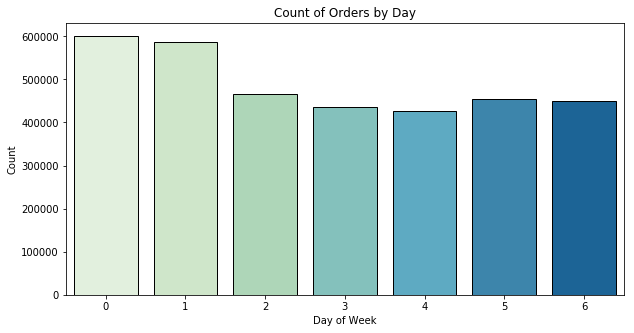

In [94]:
plt.figure(figsize=(10,5))

# Countplot of orders per dow
ax = sns.countplot(x=data['orders']['order_dow'], palette='GnBu', edgecolor='k')

# Format plot
ax.set_title('Count of Orders by Day')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Count')

plt.show()

It is still unknown as to whether this scale represent Mon-Sun or Sun-Sat, but perhaps future analysis of purchase behavior can help indicate which is more likely. Initial conjecture based of counts above would be that the largest volume of purchases happen Sunday/Monday versus Monday/Tuesday, but we will ultimately need to see if other data supports this hypothesis.

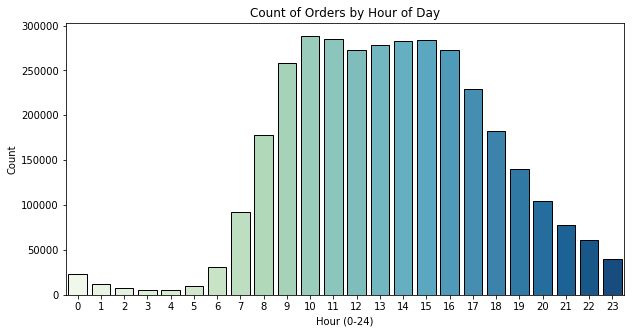

In [96]:
plt.figure(figsize=(10,5))

# Countplot of orders per hour of day
ax = sns.countplot(x=data['orders']['order_hour_of_day'], palette='GnBu', edgecolor='k')

# Format plot
ax.set_title('Count of Orders by Hour of Day')
ax.set_xlabel('Hour (0-24)')
ax.set_ylabel('Count')

plt.show()

Two slights humps in the late morning and afternoon, but as a whole the majority of orders are focused around the 9AM-5PM interval.

Taking a look at the same distribution split by day:

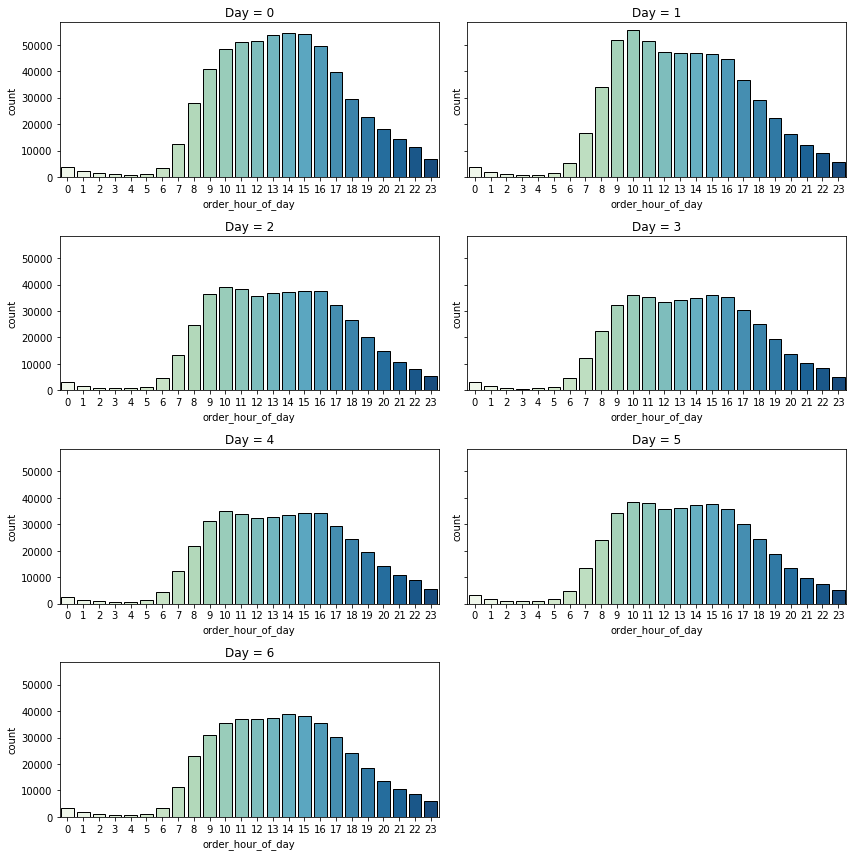

In [140]:
fig, axs = plt.subplots(4,2, figsize=[12,12], sharey=True)

# Plot orders counts for each dow
for dow in range(7):
    ax = axs.flatten()[dow]
    sns.countplot(x=data['orders'][data['orders']['order_dow'] == dow]['order_hour_of_day'], palette='GnBu', edgecolor='k', ax=ax)
    ax.set_title('Day = {}'.format(dow))

# delete last subplot (odd number of plots since dow=7)
fig.delaxes(axs.flatten()[-1])
plt.tight_layout()
plt.show()

Days 0 and 6 appear to share a somewhat similar pattern of a single hump in orders towards the afternoon, whereas all other days show the double maximums in the morning/afternoon observed earlier. This could further suggest that day 0 is Sunday (and 6 is Saturday).

Moving on to orders and users:

In [171]:
data['orders']['user_id'].nunique()

206209

As mentioned on the Kaggle page, we are working with just over 200,000 users. Looking at the number of orders each user has on record:

In [157]:
data['orders']['user_id'].value_counts().describe()

count   206209.00
mean        16.59
std         16.65
min          4.00
25%          6.00
50%         10.00
75%         20.00
max        100.00
Name: user_id, dtype: float64

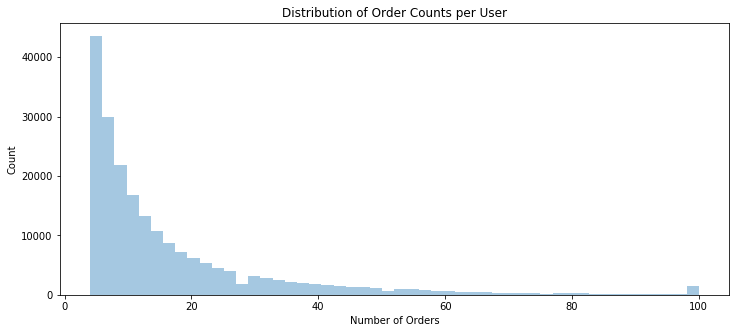

In [166]:
plt.figure(figsize=(12,5))

# Distribution of orders per user, default bins = 20
ax = sns.distplot(data['orders']['user_id'].value_counts(), kde=False)

ax.set_title('Distribution of Order Counts per User')
ax.set_xlabel('Number of Orders')
ax.set_ylabel('Count')

plt.show()

We can see that the number of orders strongly gravitates toward the 4-10 range, with 50% of users having placed 10 orders or less. It should also be noted that order numbers appear to be capped at 100 due to the unnatural peak in volume for the maximum value of 100 orders.

Fortunately, with a minimum order count of 4 per user we have at least a basic guarantee of having some information for each user. However, the analysis above is working with the entire 3 datasets so we need to ensure our training (prior) dataset also has enough information per user:

In [170]:
data['orders'][data['orders']['eval_set'] == 'prior']['user_id'].value_counts().describe()

count   206209.00
mean        15.59
std         16.65
min          3.00
25%          5.00
50%          9.00
75%         19.00
max         99.00
Name: user_id, dtype: float64

Our minimum number of orders per user in working with our training dataset is 3. In an ideal world we would want 10-20 observations per user, but we at least have more than 1 record per user (which in itself may contain multiple items ordered) to work with in producing recommendations, somewhat mitigating the cold start problem.

Exploring how much of our customer base is available for each level of order quantities:

In [25]:
N = data['orders'][data['orders']['eval_set'] == 'prior'].groupby(['user_id'])['order_id'].count()
for i in range(3,11):
    n = sum(N >= i)
    print('Number of customers with >= {} orders: {} ({:.1f}%)'.format(i, n, n / N.shape[0] * 100))

Number of customers with >= 3 orders: 206209 (100.0%)
Number of customers with >= 4 orders: 182223 (88.4%)
Number of customers with >= 5 orders: 162633 (78.9%)
Number of customers with >= 6 orders: 146468 (71.0%)
Number of customers with >= 7 orders: 132618 (64.3%)
Number of customers with >= 8 orders: 120918 (58.6%)
Number of customers with >= 9 orders: 110728 (53.7%)
Number of customers with >= 10 orders: 101696 (49.3%)


We can see that at a cut-off of 10 or more orders we are only left with just under 50% of our original set of customers. Considering our large dataset size, however, it may be worthwhile for the sake of performance to limit ourselves to such a minimum. At the very least, the minimum of 5 orders still leaves us with almost 80% of customers to work with. Translating these possibilities to our total number of orders to be processed:

In [67]:
user_orders = data['orders'][data['orders']['eval_set'] == 'prior'].groupby(['user_id'])
for i in range(3,11):
    users = (user_orders['order_id'].count() >= i)
    users = users[users==True]
    n_orders = data['orders'][(data['orders']['eval_set'] == 'prior') & (data['orders']['user_id'].isin(users.keys()))].shape[0]
    print('Number of orders using customers with >= {} orders: {} ({:.1f}%)'.format(i, n_orders, n_orders / data['orders'][data['orders']['eval_set'] == 'prior'].shape[0] * 100))

Number of orders using customers with >= 3 orders: 3214874 (100.0%)
Number of orders using customers with >= 4 orders: 3142916 (97.8%)
Number of orders using customers with >= 5 orders: 3064556 (95.3%)
Number of orders using customers with >= 6 orders: 2983731 (92.8%)
Number of orders using customers with >= 7 orders: 2900631 (90.2%)
Number of orders using customers with >= 8 orders: 2818731 (87.7%)
Number of orders using customers with >= 9 orders: 2737211 (85.1%)
Number of orders using customers with >= 10 orders: 2655923 (82.6%)


Whilst a threshold of 10 orders resulted in losing half the customer base, we can see we still utilize over 80% of the orders on record. This somewhat mitigates concerns with potentially choosing such a threshold to reduce the volume of data we are dealing with and improve information available per customer, but at thresholds of 10 orders (and higher) it is still hard to justify losing half of the customer base in evaluation. The ultimate decision as to how much data is excluded will likely come down to performance constraints when modelling.

Moving on to the days since prior order column:

In [176]:
data['orders']['days_since_prior_order'].describe()

count   3214874.00
mean         11.11
std           9.21
min           0.00
25%           4.00
50%           7.00
75%          15.00
max          30.00
Name: days_since_prior_order, dtype: float64

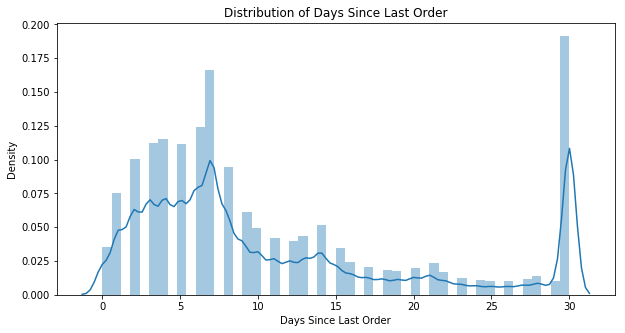

In [189]:
plt.figure(figsize=(10,5))

ax = sns.distplot(data['orders'].dropna()['days_since_prior_order'], )

ax.set_title('Distribution of Days Since Last Order')
ax.set_xlabel('Days Since Last Order')
ax.set_ylabel('Density')

plt.show()

We can see that the majority of re-orders happen in the 0-10 day range. Again, we have an unnatural peak at the maximum value of 30 days, suggesting that this value was clipped for larger values. It may be necessary to discount this disproportionate volume of orders at 30 days.

Taking a look at the possible changes in mean time intervals between orders and the number of orders placed:

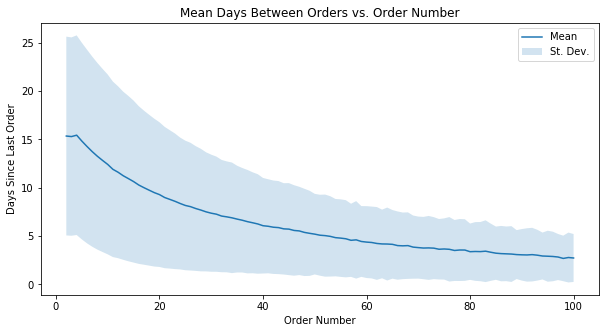

In [219]:
plt.figure(figsize=(10,5))

ax = data['orders'].groupby('order_number')['days_since_prior_order'].mean().plot(label='Mean')
ax.fill_between(x = data['orders'].groupby('order_number')['days_since_prior_order'].std().index.values,
                 y1 = data['orders'].groupby('order_number')['days_since_prior_order'].mean() - data['orders'].groupby('order_number')['days_since_prior_order'].std(),
                 y2 = data['orders'].groupby('order_number')['days_since_prior_order'].mean() + data['orders'].groupby('order_number')['days_since_prior_order'].std(),
                 alpha=0.2, label='St. Dev.')

ax.set_title('Mean Days Between Orders vs. Order Number')
ax.set_xlabel('Order Number')
ax.set_ylabel('Days Since Last Order')

ax.legend()

plt.show()

The decay in time intervals between orders as well as its standard deviation with increasing order number aligns with the notion that long term customers begin shopping on more regular intervals. This could prove useful in building recommenders specific to the number of orders & timing.

### Basic Exploration: Order Products (Priors/Train)

In [400]:
# Make a temporary copy for convenience
df = data['order_products__prior'].copy()

In [264]:
df.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [296]:
# Number of orders
df['order_id'].nunique()

3214874

Taking a look at the number of items per order (i.e. basket size):

In [272]:
df['order_id'].value_counts().describe()

count   3214874.00
mean         10.09
std           7.53
min           1.00
25%           5.00
50%           8.00
75%          14.00
max         145.00
Name: order_id, dtype: float64

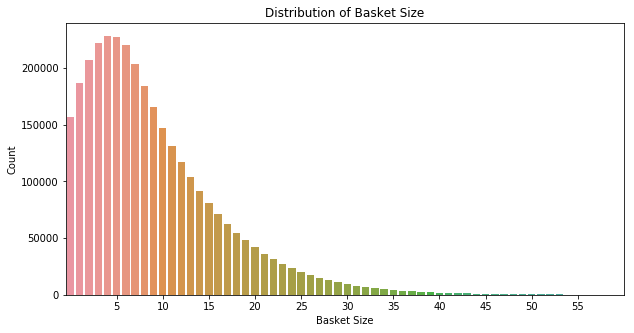

In [289]:
plt.figure(figsize=(10,5))

ax = sns.countplot(df['order_id'].value_counts())

ax.set_xticks(np.arange(5,60,5))
ax.set_xticklabels(np.arange(5,60,5))
ax.set_xlim(right=60)

ax.set_title('Distribution of Basket Size')
ax.set_xlabel('Basket Size')
ax.set_ylabel('Count')

plt.show()

Majority of orders fall in the range of 1-10 items per order. It is also worth noting a select few basket sizes reach up to 100+ items (cut off from the graph above):

In [294]:
# Number of basket sizes above 100
sum(df['order_id'].value_counts() > 100)

20

In [306]:
# Number of basket sizes above 50
print(sum(df['order_id'].value_counts() > 50))

# % orders with basket sizes above 50
print(sum(df['order_id'].value_counts() > 50)/df['order_id'].nunique() * 100)

3081
0.09583579325348365


In [307]:
# Number of basket sizes above 20
print(sum(df['order_id'].value_counts() > 20))

# % orders with basket sizes above 20
print(sum(df['order_id'].value_counts() > 20)/df['order_id'].nunique() * 100)

303410
9.437694914326347


Fortunately this seems to be limited to just 20 out of our 3+ million orders. Extending our search to basket sizes above 50 yields just over 3,000 orders, which still only comprises 0.1% of our data. Once we reach basket of sizes of 20, however, we start seeing a considerable portion of data (approx. 10%). It may be worth keeping the potential for large basket sizes in consideration, particularly when working with association rules.

It is possible that these large basket sizes are a result of certain products beings ordered in large quantities (e.g. 10-20 of the same item being added vs 10-20 unique products):

In [314]:
# Count of orders with duplicate product ids
sum(df.groupby(['order_id','product_id'])['product_id'].count() > 1)

0

No orders exist in which the same product is accounted for more than once, indicating that the quantity of an item ordered is not captured.

Moving on to the products purchased:

In [335]:
# Number of unique products present in orders
df['product_id'].nunique()

49677

In [319]:
# Purchase counts per individual product
df['product_id'].value_counts().describe()

count    49677.00
mean       652.91
std       4792.11
min          1.00
25%         17.00
50%         60.00
75%        260.00
max     472565.00
Name: product_id, dtype: float64

In [333]:
# Number of products only purchased once
sum(df['product_id'].value_counts() == 1)

131

The majority of products have been purchased less than 100 times across our 3 million orders. Additionally, we have 131 products which have only been purchased once. Making recommendations for products with a limited history of purchase means relying solely on popularity of items will lead to some biased results.

We also have some large outliers, with a maximum purchase count of 470k:

In [337]:
# Products with over 100k purchases
sum(df['product_id'].value_counts() > 100000)

15

15 products have been purchased over 100,000 times. We will need to look into what these extremely popular products are once we join this table with the product names.

In [339]:
# 90th percentile for number of purchases per product
df['product_id'].value_counts().quantile(0.9)

1021.0

As a whole, approximately 90% of products have been purchases 1,000 times or less. Relative to our dataset of 3 million orders, we will need to see how this sparsity translates to our recommendation capabilities. Simplifying products into broader categories may prove necessary.

Out of curiosity we will see how many reorders we have:

In [402]:
df['reordered'].value_counts() / df.shape[0]

1   0.59
0   0.41
Name: reordered, dtype: float64

Approximeately 59% of the ordered items are reorders. This a good initial indicator that building recommendations of previously ordered items may prove succesful.

### Basic Exploration: Products

In [403]:
df = data['products'].copy()

In [342]:
df.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [347]:
# Total number of unique products
df.shape[0]

49688

Compared to our order table, we can see that almost every product has at least 1 purchase with the exception of 11 items (46777 purchased vs. 49688 on record). Taking a look at what we are missing:

In [396]:
# Create temp merged dataframe of products with order counts
temp = pd.merge(data['products'], pd.DataFrame(data['order_products__prior'].groupby('product_id')['order_id'].count()).rename(columns={'order_id':'order_count'}), left_on='product_id', right_index=True, how='left').fillna(0)

Taking a look out the items which were never ordered:

In [397]:
temp[temp['order_count'] == 0]

product_id                                       product_name  \
3629         3630                        Protein Granola Apple Crisp   
3717         3718                   Wasabi Cheddar Spreadable Cheese   
7044         7045             Unpeeled Apricot Halves in Heavy Syrup   
25382       25383                                 Chocolate Go Bites   
27498       27499                  Non-Dairy Coconut Seven Layer Bar   
36232       36233                            Water With Electrolytes   
37702       37703  Ultra Sun Blossom Liquid 90 loads Fabric Enhan...   
43724       43725                               Sweetart Jelly Beans   
45970       45971                         12 Inch Taper Candle White   
46624       46625    Single Barrel Kentucky Straight Bourbon Whiskey   
49539       49540                            Pure Squeezed  Lemonade   

       aisle_id  department_id  order_count  
3629         57             14         0.00  
3717         21             16         0.00  
7044         88             13         0.00  
25382        61             19         0.00  
27498       100             21         0.00  
36232       100             21         0.00  
37702        75             17         0.00  
43724       100             21         0.00  
45970       101             17         0.00  
46624        31              7         0.00  
49539        31              7         0.00

Nothing immediately discernable from these items, but we can guess that these are likely niche products. As for the most popular products identified earlier with order counts on the magnitidue of 100k:

In [399]:
temp.sort_values(by='order_count', ascending=False).head(20)

product_id              product_name  aisle_id  department_id  \
24851       24852                    Banana        24              4   
13175       13176    Bag of Organic Bananas        24              4   
21136       21137      Organic Strawberries        24              4   
21902       21903      Organic Baby Spinach       123              4   
47208       47209      Organic Hass Avocado        24              4   
47765       47766           Organic Avocado        24              4   
47625       47626               Large Lemon        24              4   
16796       16797              Strawberries        24              4   
26208       26209                     Limes        24              4   
27844       27845        Organic Whole Milk        84             16   
27965       27966       Organic Raspberries       123              4   
22934       22935      Organic Yellow Onion        83              4   
24963       24964            Organic Garlic        83              4   
45006       45007          Organic Zucchini        83              4   
39274       39275       Organic Blueberries       123              4   
49682       49683            Cucumber Kirby        83              4   
28203       28204        Organic Fuji Apple        24              4   
5875         5876             Organic Lemon        24              4   
8276         8277  Apple Honeycrisp Organic        24              4   
40705       40706    Organic Grape Tomatoes       123              4   

       order_count  
24851    472565.00  
13175    379450.00  
21136    264683.00  
21902    241921.00  
47208    213584.00  
47765    176815.00  
47625    152657.00  
16796    142951.00  
26208    140627.00  
27844    137905.00  
27965    137057.00  
22934    113426.00  
24963    109778.00  
45006    104823.00  
39274    100060.00  
49682     97315.00  
28203     89632.00  
5875      87746.00  
8276      85020.00  
40705     84255.00

Here we see that produce (fruits/vegetables) are clearly dominating in order counts. We have not taken a focused look at aisle/department counts just yet, but it is already evident that department 4 and aisle 24 are likely to be the most popular and reoccuring.

Looking through some of the product names listed above, it is evident hat we have a lot of similar items with slight variations (e.g. bananas vs. bag of organic bananas). If we explore some products sharing the same words/naming:

In [410]:
df[df['product_name'].str.contains('[Bb]anana')]

product_id                                       product_name  \
62             63      Banana & Sweet Potato Organic Teething Wafers   
312           313  Peppermint/Banana Split Variety Pack Frozen Da...   
425           426                                  2nd Foods Bananas   
601           602                              Banana Chocolate Chip   
848           849  Blueberry & Banana Tiny Fruits Freeze Dried Sn...   
865           866                   Flavor & Fiber Banana Walnut Bar   
910           911               Protein Shake, Organic, Banana Creme   
1016         1017                            Strawberry Banana Juice   
1017         1018  Kids Organic Mashups Squeezable Fruit Strawber...   
1228         1229             Restore Banana Kale Banana & Pineapple   
1347         1348             Strawberry Banana Fruit Juice Smoothie   
1348         1349                      Greek Yogurt Banana & Pumpkin   
1399         1400                                     Banana Pudding   
1442         1443                  Strawberry and Banana Fruit Puree   
1456         1457  Banana Protein Kefir Nonfat Cultured Milk Smoo...   
1465         1466  Blended Breakfast Strawberry+Banana+Chia+Ancie...   
1473         1474                          Wax Peppers, Sweet Banana   
1620         1621  Organic Vitality Snack Chia Squeeze Strawberry...   
1652         1653   Organic Nibbly Fingers Stage 3 Bananas & Raisins   
2010         2011                           Banana Peach & Raspberry   
2109         2110                                      Green Bananas   
2188         2189                        Banana Low-Fat Greek Yogurt   
2458         2459              Quinoa and Banana Organic Baby Cereal   
2476         2477                  Organic Bananas Stage 2 Baby Food   
2483         2484  Organic Kiwi, Banana, & Apple with Super Grain...   
2744         2745         Strawberry Explosion/Banana Split Smoothie   
2759         2760                Organic Apple Cinnamon Banana Bites   
2828         2829  Organic Stage 2 Apple, Banana & Butternut Squa...   
2847         2848                 Strawberry Orange Banana Drink Mix   
2864         2865          Probiotics 100% Strawberry & Banana Juice   
...           ...                                                ...   
45866       45867      2nd Foods Organic Banana and Squash Baby Food   
45922       45923           Organic Black Bean Beet Banana Baby Food   
45984       45985           Organic Yogurt Melts - Strawberry Banana   
46114       46115                             Banana  Granola Cereal   
46300       46301                            Banana Nut Mini Muffins   
46339       46340                    Imitation Banana Flavor Extract   
46709       46710               Graduates Waffle Wheels Banana Cream   
46710       46711                                Banana Cream Crunch   
46806       46807      Bananas, Raspberries & Oats Organic Baby Food   
46830       46831        Triple Zero Banana Creme Oikos Greek Yogurt   
47103       47104                                    Banana Oat Bars   
47178       47179           Peach Apricot & Banana Stage 2 Baby Food   
47212       47213                    Strawberry Banana Nonfat Yogurt   
47232       47233                            Bananas, Dark Chocolate   
47592       47593            Tots Yogurt Mish Mash Berry Banana Beet   
47718       47719              Banana Raspberry & Brown Rice Stage 2   
48102       48103        Mini Banana Chocolate Chip Bars Snack Cakes   
48300       48301              Strawberry Banana Coconut Milk Yogurt   
48314       48315  3F Banana Apple Mango with Lil' Bits Purees Fruit   
48433       48434                      Strawberry Banana Super Drink   
48545       48546                                Banana Smoothie Mix   
48706       48707                                Banana Mango Yogurt   
48978       48979                                 Banana Twins Cakes   
49017       49018             Strawberry & Bana

In the case of 'Banana', we have 376 products with the word banana. This is not to say that all of these are products are similar or identical - for instance we have banana twin cakes versus bananas peppers which are two rather disparate items. However, there are few instances where there are minor variations of the same concept, or at the very least we see banana prevalent as a flavoring throughout these items. It may be beneficial to explore utilizing common word features to identify favorite tastes, for example in this context finding users who show a strong liking toward banana & banana flavored items to then recommend other items of similar or compatible flavors.

### Basic Exploration: Department

In [415]:
df = data['departments'].copy()

In [416]:
df.shape

(21, 2)

In [417]:
df.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

Departments appear to be a broad categorization of products, with 21 possibilities. Let us first take a look at how many products we have in each department:

In [470]:
temp = pd.merge(data['products'], data['departments'], on='department_id')

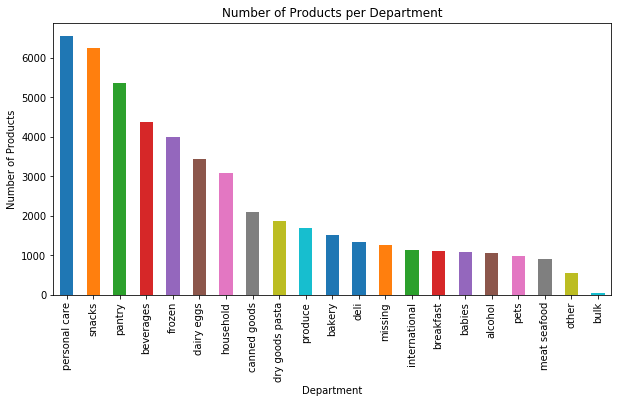

In [491]:
plt.figure(figsize=(10,5))

ax = temp.groupby('department')['product_id'].nunique().sort_values(ascending=False).plot.bar()

ax.set_title('Number of Products per Department')
ax.set_xlabel('Department')
ax.set_ylabel('Number of Products')

plt.show()

Next let us join this table with our orders to see how purchases are distributed:

In [482]:
temp = pd.merge(data['order_products__prior'], data['products'], on='product_id').merge(data['departments'], on='department_id')

In [424]:
temp.head()

order_id  product_id  add_to_cart_order  reordered        product_name  \
0         2       33120                  1          1  Organic Egg Whites   
1        26       33120                  5          0  Organic Egg Whites   
2       120       33120                 13          0  Organic Egg Whites   
3       327       33120                  5          1  Organic Egg Whites   
4       390       33120                 28          1  Organic Egg Whites   

   aisle_id  department_id  department  
0        86             16  dairy eggs  
1        86             16  dairy eggs  
2        86             16  dairy eggs  
3        86             16  dairy eggs  
4        86             16  dairy eggs

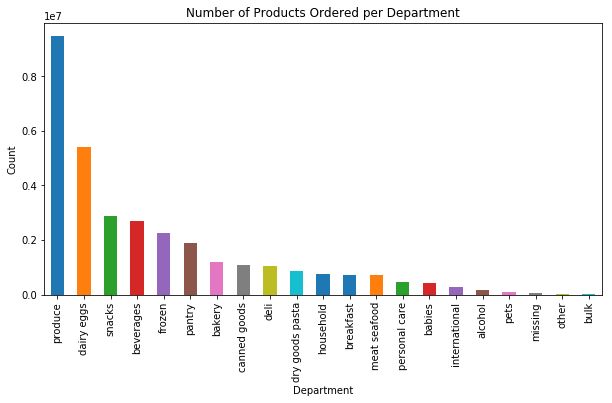

In [490]:
plt.figure(figsize=(10,5))

ax = temp['department'].value_counts().sort_values(ascending=False).plot.bar()

ax.set_title('Number of Products Ordered per Department')
ax.set_xlabel('Department')
ax.set_ylabel('Count')

plt.show()

In [463]:
# % of orderered items comprising produce or dairy/eggs
sum(((temp['department'] == 'produce') | (temp['department'] == 'dairy eggs'))) / temp.shape[0]

0.4591811821052584

Produce and dairy/eggs are clearly the dominating departments, making up 46% of ordered items. Compared to our original product counts per department, we can see that whilst the most products available are in personal care, they actually constitue a small fraction of purchases.

We can try to capture a rough essence of popularity by weighing these purchase counts against the proportion of products available:

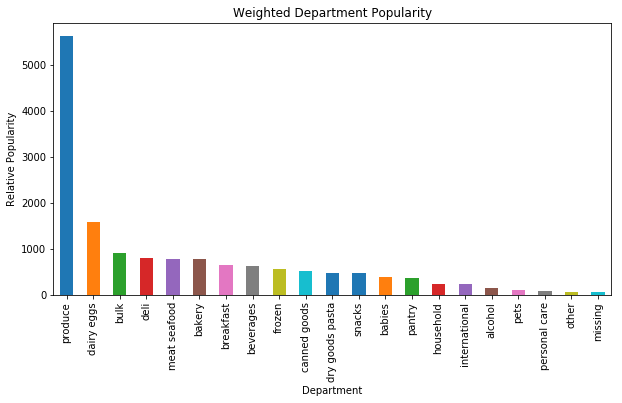

In [489]:
plt.figure(figsize=(10,5))

# Plot product order counts per department as fraction of total products available in said department
ax = (temp['department'].value_counts().sort_index() / temp.groupby('department')['product_id'].nunique().sort_index()).sort_values(ascending=False).plot.bar()

ax.set_title('Weighted Department Popularity')
ax.set_xlabel('Department')
ax.set_ylabel('Relative Popularity')

plt.show()

Whilst this view does not necessarily yield much insight with regards to our recommender system approach, it is interesting from a business perspective as to the approximate value/efficiency of stocking certain items. For example, even with the limited selection of produce relative to the number of personal care products, the amount of purchases and visibility of produce items greatly exceeds that of personal care items.

One concern worth noting before proceeding to aisle exploration is the "missing" department. Taking a look at some of the items in this department:

In [497]:
# Number of products in 'missing' department
temp[temp['department']=='missing']['product_name'].nunique()

1255

In [498]:
# Sample of 'missing' department products
temp[temp['department']=='missing']['product_name'].unique()[:20]

array(['Tomato Basil Bisque Soup',
       'Cold Pressed Watermelon & Lemon Juice Blend',
       'Paleo Blueberry Muffin', 'Organic Poblano Pepper',
       'Organic Plain Unsweetened Nondairy Cashew Yogurt',
       'Liquid Kimchi Tangy Vegan Fermented & Probiotic Spicy Elixir',
       'Cilantro Bunch', 'Noodle Chicken',
       'Organic Pineapple Cottage Cheese',
       'Oven Baked Original Potato Crisps',
       'Organic Nondairy Strawberry Cashew Yogurt',
       'Organic Ginseng Mandarin Tonic',
       'Simply 100 Crunch Vanilla Coconut Macaron Non-Fat Greek Yogurt',
       'Soft & Chewy Strawberry Newtons',
       'Natural Lemon Flavored Sparkling Water',
       'Herbal Tea Bags Organic Turmeric With Meadowsweet & Ginger 16 Ct',
       'Sea-Salt Grain-Free Tortilla Chips', 'Milk Chocolate Bunny',
       'Pasilla Pepper (Chile Negro)', 'Green Lemonade'], dtype=object)

These 'missing' department items do not seem to follow any consistent theme, with a variety of foods and beverages we would expect to find in some of our other department labels. It may be necessary to discard these items from our recommender, at least in scenarios where department is being leveraged in decisioning. Alternatively, we can attempt to assign appropriate labels based off our understanding of department definitions, but this is likely to be a highly manual process of involving the 1255 records. We also do not know if Instacart has intentionally marked these items as missing due to discontinuation of products or other unique circumstances.

Whilst we have not looked at the aisles just yet, this cleaning effort may also be further complicated if aisle information is also missing. Looking at records missing department and (potentially) not missing aisle:

In [506]:
# aisle ID for missing
data['aisles'][data['aisles']['aisle'] == 'missing']

aisle_id    aisle
99       100  missing

In [507]:
# Number of missing departments not missing aisle
sum((temp['department'] == 'missing') & (temp['aisle_id'] != 100))

0

Every instance of missing department is also missing aisle, so this will at least double the effort required in trying to interpret and assign both correct department and aisles to these items.

### Basic Exploration: Aisles

In [464]:
df = data['aisles'].copy()

In [413]:
df.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [414]:
df.shape

(134, 2)

We have 134 aisles to work with. Performing a similar analysis of order distribution across aisles:

In [85]:
temp = pd.merge(data['products'], data['departments'], on='department_id').merge(data['aisles'], on='aisle_id')

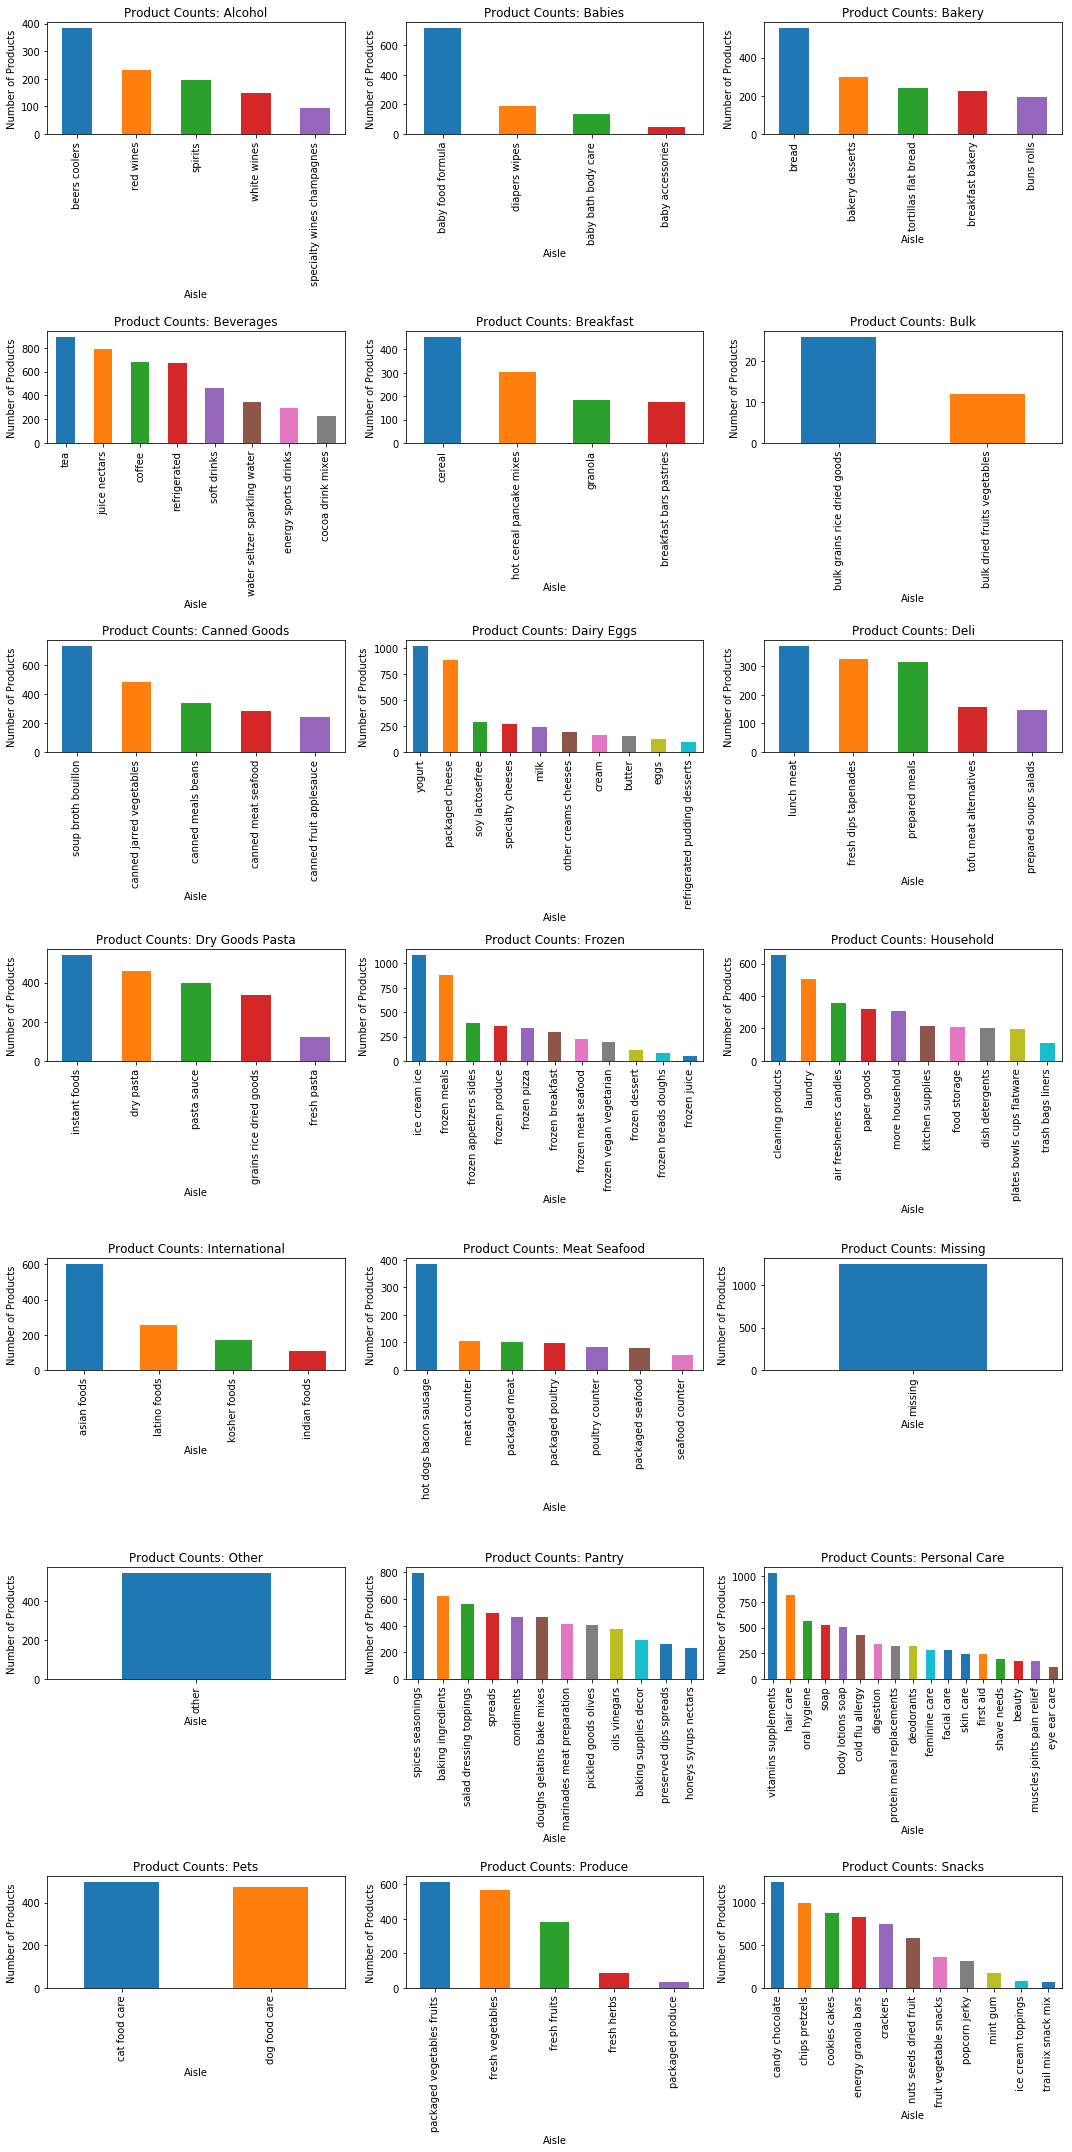

In [86]:
depts = temp['department'].unique()
depts.sort()

n_cols = 3
n_rows = len(depts)//n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols,10*n_cols))

for i, dept in enumerate(depts):
    mask = temp['department'] == dept
    ax = axs.flatten()[i]
    temp[mask]['aisle'].value_counts().plot.bar(ax=ax)
    ax.set_title('Product Counts: {}'.format(dept.title()))
    ax.set_xlabel('Aisle')
    ax.set_ylabel('Number of Products')

plt.tight_layout()
plt.show()

We will refrain from exploring the details of each aisle in too much depth, but we can at least see that within any department there are typically 1-3 aisles with the largest proportion of products. Repeating the above view with the number of products ordered within each aisle:

In [87]:
temp = pd.merge(data['order_products__prior'], data['products'], on='product_id').merge(data['departments'], on='department_id').merge(data['aisles'], on='aisle_id')

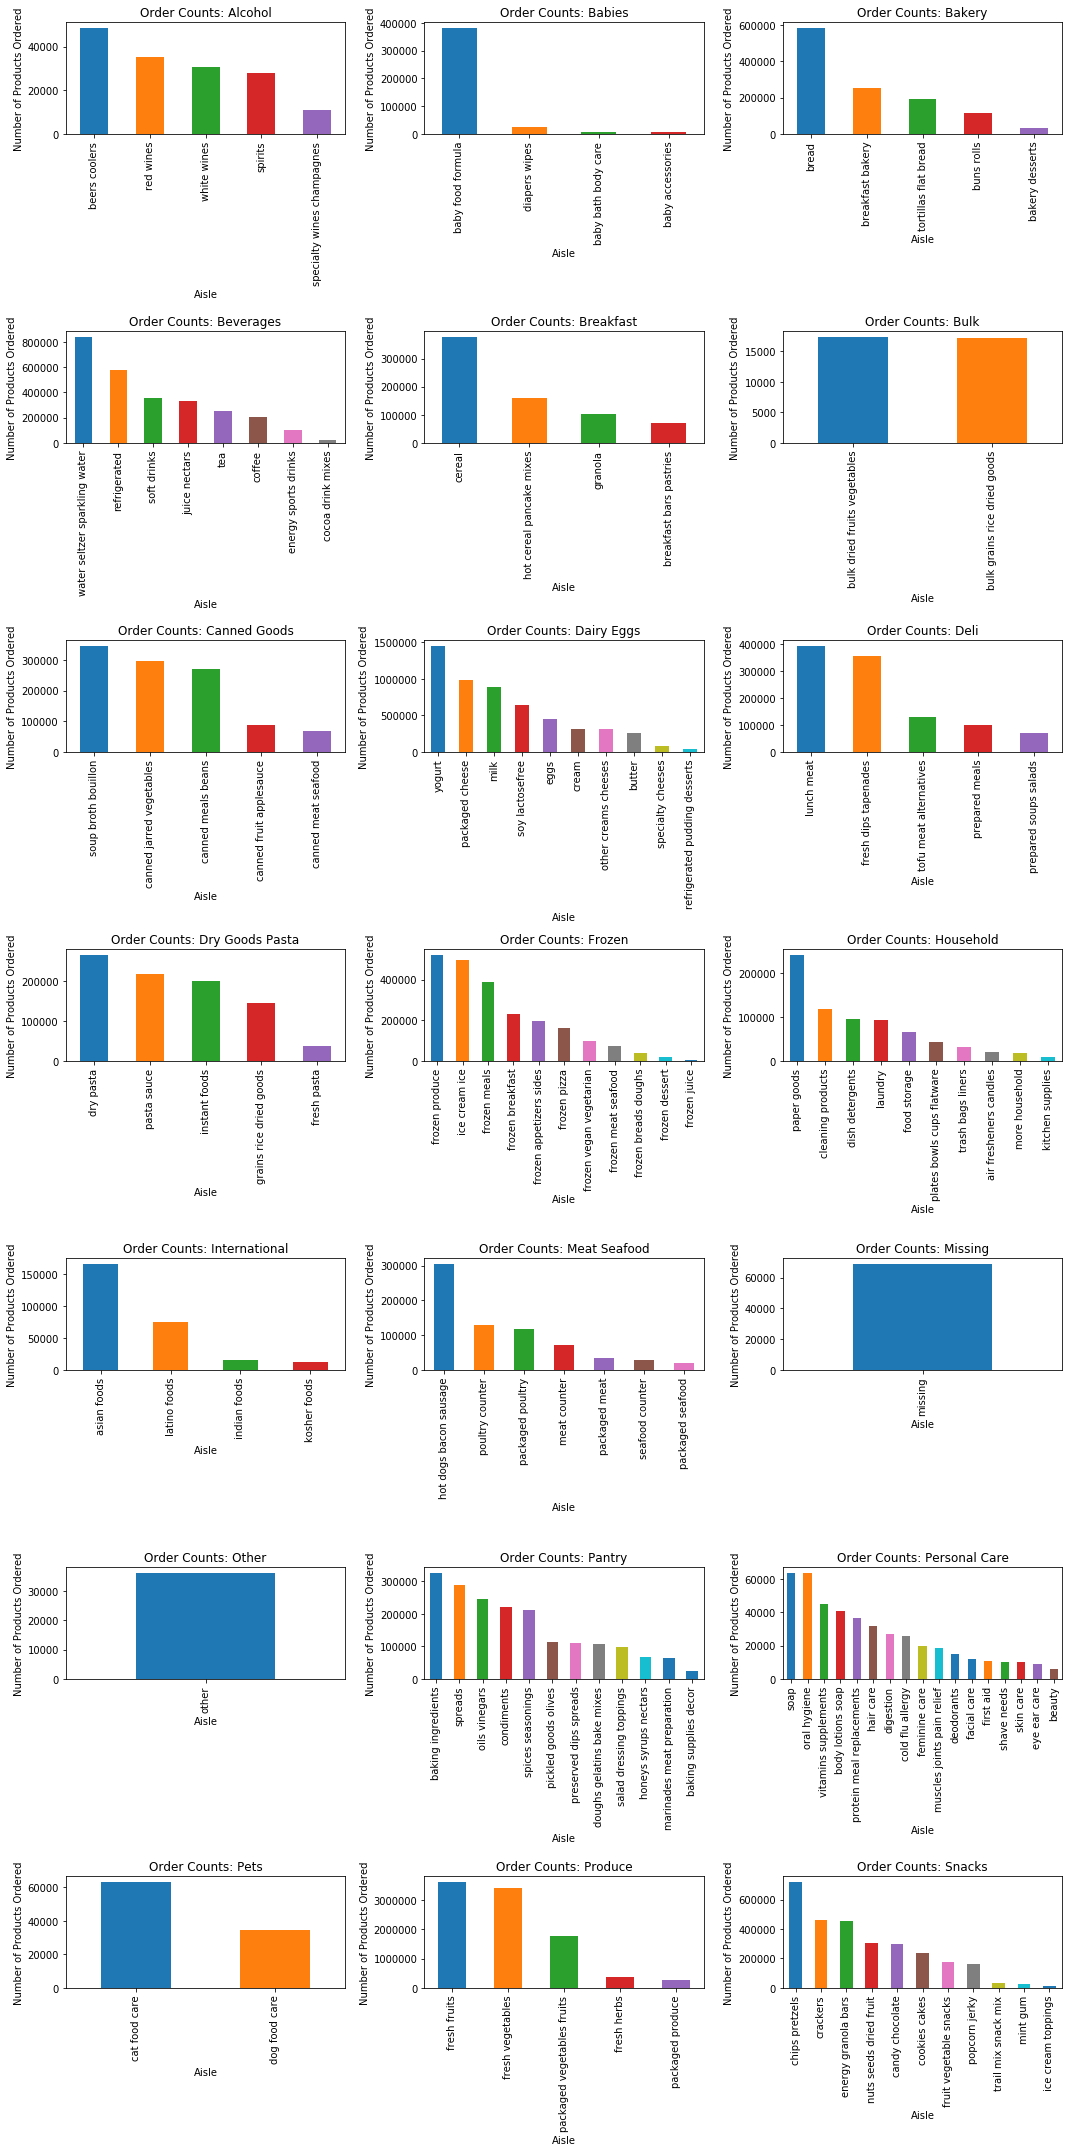

In [88]:
depts = temp['department'].unique()
depts.sort()

n_cols = 3
n_rows = len(depts)//n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols,10*n_cols))

for i, dept in enumerate(depts):
    mask = temp['department'] == dept
    ax = axs.flatten()[i]
    (temp[mask]['aisle'].value_counts()).sort_values(ascending=False).plot.bar(ax=ax)
    ax.set_title('Order Counts: {}'.format(dept.title()))
    ax.set_xlabel('Aisle')
    ax.set_ylabel('Number of Products Ordered')

plt.tight_layout()
plt.show()

As with our departments, the most populated aisles do not necessarily correspond to the most purchased. For example, we can see that sparkling selzer water is much more succesful in terms of purchase quantity versus the number of products available.

### Full Data Exploration

Build a dataframe with all 'prior' orders & products:

In [6]:
data_prior = pd.merge(data['orders'], data['order_products__prior'], on='order_id')\
               .merge(data['products'].merge(data['departments'], on='department_id').merge(data['aisles'], on='aisle_id'), on='product_id')

In [94]:
data_prior.shape

(32434489, 15)

In [95]:
data_prior.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                     NaN         196                  1          0   
1                    15.0         196                  1          1   
2                    21.0         196                  1          1   
3                    29.0         196                  1          1   
4                    28.0         196                  1          1   

  product_name  aisle_id  department_id department        aisle  
0         Soda        77              7  beverages  soft drinks  
1         Soda        77              7  beverages  soft drinks  
2         Soda        77              7  beverages  soft drinks  
3         Soda        77              7  beverages  soft drinks  
4         Soda        77              7  beverages  soft drinks

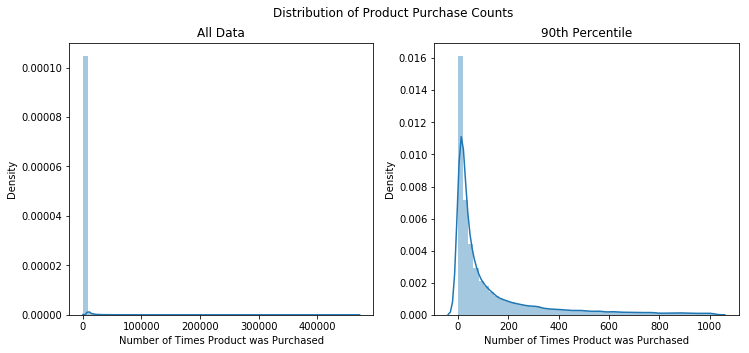

In [177]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

plot_data = data_prior['product_id'].value_counts()
q_mask = plot_data < plot_data.quantile(.90)

sns.distplot(plot_data, ax=axs[0])
sns.distplot(plot_data[q_mask], ax=axs[1])

for ax in axs:    
    ax.set_xlabel('Number of Times Product was Purchased')
    ax.set_ylabel('Density')

axs[0].set_title('All Data')
axs[1].set_title('90th Percentile')
    
fig.suptitle('Distribution of Product Purchase Counts')
    
plt.show()

In [178]:
data_prior['product_id'].value_counts().describe()

count     49677.000000
mean        652.907563
std        4792.114416
min           1.000000
25%          17.000000
50%          60.000000
75%         260.000000
max      472565.000000
Name: product_id, dtype: float64

In [184]:
npp = data_prior['product_id'].nunique()

print('{}/{} products purchased (coverage = {:.2f}%)'.format(npp,data['products'].shape[0], 100*npp/data['products'].shape[0]))

49677/49688 products purchased (coverage = 99.98%)


In [188]:
pvc = data_prior['product_id'].value_counts()

for i in range(1,11):
    n = sum(data_prior['product_id'].value_counts() <= i) + 11
    print('Number of products with <= {} purchases: {} ({:.2f}%)'.format(i, n, 100*n/data['products'].shape[0]))

Number of products with <= 1 purchases: 142 (0.29%)
Number of products with <= 2 purchases: 466 (0.94%)
Number of products with <= 3 purchases: 1107 (2.23%)
Number of products with <= 4 purchases: 2070 (4.17%)
Number of products with <= 5 purchases: 3182 (6.40%)
Number of products with <= 6 purchases: 4245 (8.54%)
Number of products with <= 7 purchases: 5307 (10.68%)
Number of products with <= 8 purchases: 6314 (12.71%)
Number of products with <= 9 purchases: 7176 (14.44%)
Number of products with <= 10 purchases: 8006 (16.11%)


Fortunately, only 11 products out of the 49k have never been purchased. However, we do have a number of products with a relatively sparse purchase history with over 8000 products having only been purchased 10 or fewer times. With respect to the overall set of products available this amounts to 16% of the product inventory having very limited interactions, which will prove challenging when aiming recommending such products.

Taking a closer look at the distribution in customer purchases:

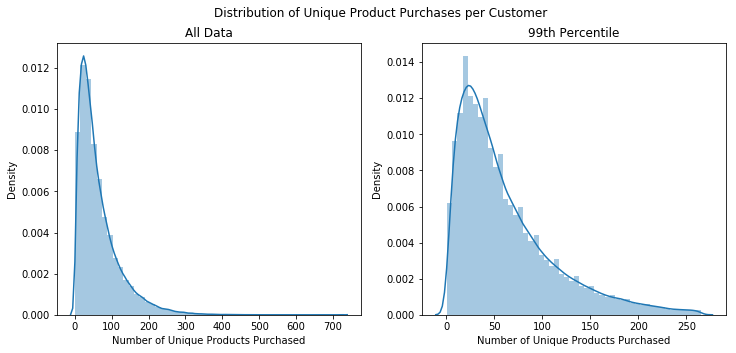

In [168]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

plot_data = data_prior.groupby('user_id')['product_id'].nunique()
q_mask = plot_data < plot_data.quantile(.99)

sns.distplot(plot_data, ax=axs[0])
sns.distplot(plot_data[q_mask], ax=axs[1])

for ax in axs:    
    ax.set_xlabel('Number of Unique Products Purchased')
    ax.set_ylabel('Density')

axs[0].set_title('All Data')
axs[1].set_title('99th Percentile')
    
fig.suptitle('Distribution of Unique Product Purchases per Customer')
    
plt.show()

In [171]:
data_prior.groupby('user_id')['product_id'].nunique().describe()

count    206209.000000
mean         64.536238
std          56.592339
min           1.000000
25%          25.000000
50%          48.000000
75%          86.000000
max         726.000000
Name: product_id, dtype: float64

In terms of unique products purchased, we seem to peak in range the 20-30 products purchased, with the major concentration of customers falling in the 25-85 range. In other words, we rarely see customers whose buying habits extend beyond a core set of products in this range. This can be interpeted in two ways: on the the one hand customers may be habitual in their purchase habits and prefer sticking to a core set of products they are familiar with (adding challenge to effective recommendations), but alternatively one can also argue that there is great potential to introduce customers to new products and increase coverage assuming they are willing to step outside their comfort zone.

Extending this view to a level higher with aisles:

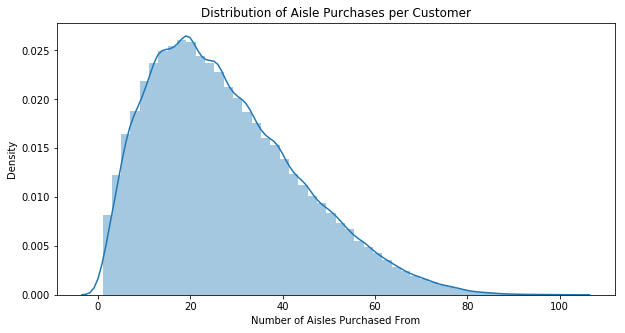

In [189]:
plt.figure(figsize=(10,5))

ax = sns.distplot(data_prior.groupby('user_id')['aisle_id'].nunique())

ax.set_title('Distribution of Aisle Purchases per Customer')
ax.set_xlabel('Number of Aisles Purchased From')
ax.set_ylabel('Density')

plt.show()

In [172]:
data_prior.groupby('user_id')['aisle_id'].nunique().describe()

count    206209.00000
mean         27.78370
std          16.11153
min           1.00000
25%          15.00000
50%          25.00000
75%          38.00000
max         102.00000
Name: aisle_id, dtype: float64

In [190]:
data['aisles']['aisle_id'].nunique()

134

We again see a majroity of customers limiting themselves to a selection of aisles from which they purchase in the 10-40 range. Relative to the total number of aisles (134), this represents a much more diverse range which is to be expected given we are dealing with fewer options. It can still be argued, however, that customers seem to favor a certain selection of aisles in their shopping habits and are less likely to expand or explore all options.

Repeating this view with distributions across departments:

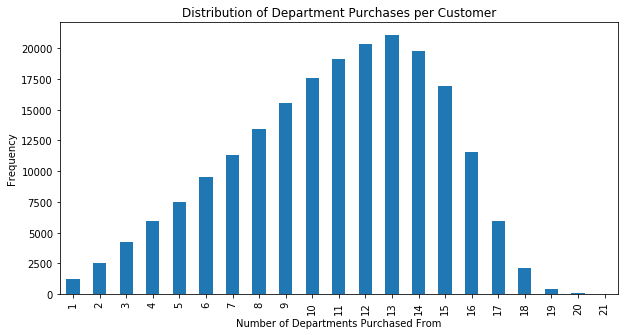

In [192]:
plt.figure(figsize=(10,5))

# Plot as bar chart instead since we have a more limited list
ax = data_prior.groupby('user_id')['department_id'].nunique().value_counts().sort_index().plot.bar(cmap=my_cmap)

ax.set_title('Distribution of Department Purchases per Customer')
ax.set_xlabel('Number of Departments Purchased From')
ax.set_ylabel('Frequency')

plt.show()

With departments we see a significant rightward shift in the distribution. This indicates that whilst for individual products and aisles customers tend to limit themselves to a smaller subset, the variety in departments from which customers shop tends to be more encompassing of all available departmenents.

We can continue this analysis of shopping variety/coverage in looking at how purchase variety changes over time (i.e. order number):

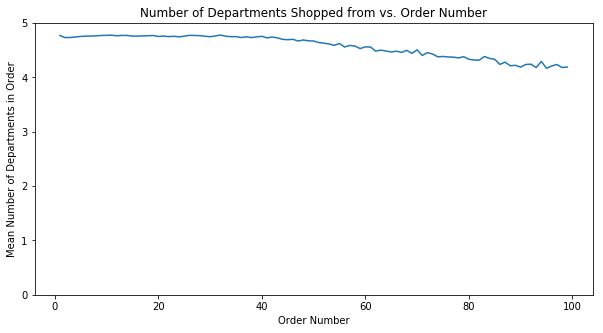

In [196]:
plt.figure(figsize=(10,5))

ax = data_prior.groupby(['order_number', 'user_id'])['department_id'].nunique().unstack().mean(axis=1).plot(cmap=my_cmap)

ax.set_title('Number of Departments Shopped from vs. Order Number')
ax.set_xlabel('Order Number')
ax.set_ylabel('Mean Number of Departments in Order')
ax.set_ylim(0,5)

plt.show()

We see a gradual, albeit relatively small, decrease in the mean number of departments in orders with increasing order numbers, which might suggest that customers hone in on their preferences and "go-to's" over time. Repeating this view for aisles:

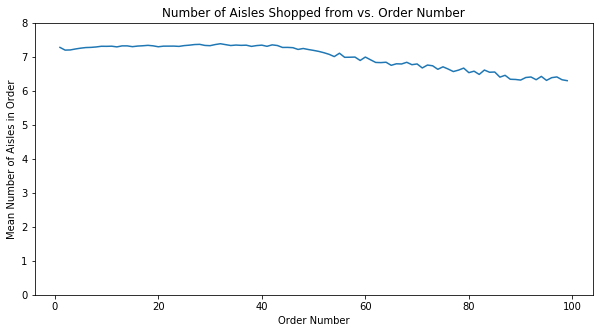

In [198]:
plt.figure(figsize=(10,5))

ax = data_prior.groupby(['order_number', 'user_id'])['aisle_id'].nunique().unstack().mean(axis=1).plot(cmap=my_cmap)

ax.set_title('Number of Aisles Shopped from vs. Order Number')
ax.set_xlabel('Order Number')
ax.set_ylabel('Mean Number of Aisles in Order')
ax.set_ylim(0,8)

plt.show()

We a similar trend with aisles, noting again that whilst there is a decrease over increasing order number the change is relatively small. Perhaps a stronger change can be observed at the individual product level:

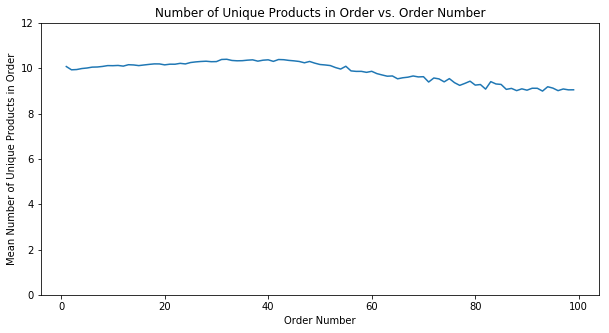

In [200]:
plt.figure(figsize=(10,5))

ax = data_prior.groupby(['order_number', 'user_id'])['product_id'].nunique().unstack().mean(axis=1).plot(cmap=my_cmap)

ax.set_title('Number of Unique Products in Order vs. Order Number')
ax.set_xlabel('Order Number')
ax.set_ylabel('Mean Number of Unique Products in Order')
ax.set_ylim(0,12)

plt.show()

We do see a similar weak downward trend, but there is a noticeable bump around 40 order number mark which could be interpreted as customers experimenting with new products before focusing back on a consistent set of purchases. All of these trends are relatively weak however so it is hard to make any hard conclusions.

Looking at the reorder rates over time (i.e. order number) may provide a stronger impression:

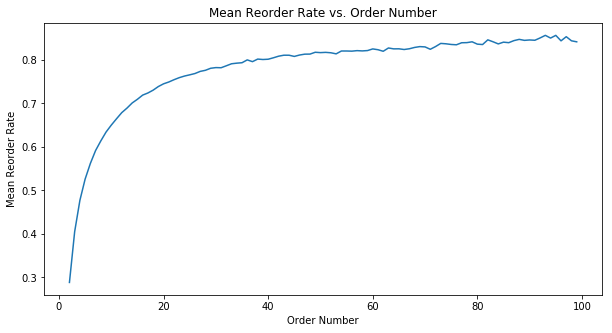

In [201]:
plt.figure(figsize=(10,5))

ax = data_prior[data_prior['order_number'] > 1].groupby(['order_number', 'user_id'])['reordered'].mean().unstack().mean(axis=1).plot(cmap=my_cmap)

ax.set_title('Mean Reorder Rate vs. Order Number')
ax.set_xlabel('Order Number')
ax.set_ylabel('Mean Reorder Rate')

plt.show()

We can see that starting at around 20 orders user reorder rates stabalize in the 0.7-0.8 range, meaning 70-80% of items ordered are reorders. We do not know if these reorders are consistently the same items, but is still does show us the establishment of a consistent purchase habit beginning at 20 orders. In the context of a recommender system, it may prove useful to prioritize past ordered items more as a customer reaches this mark.

To help fill in some of the unknowns with consistent ordering habits, we will take a look at how the set of unique purchases develops as the customer places subsequent orders:

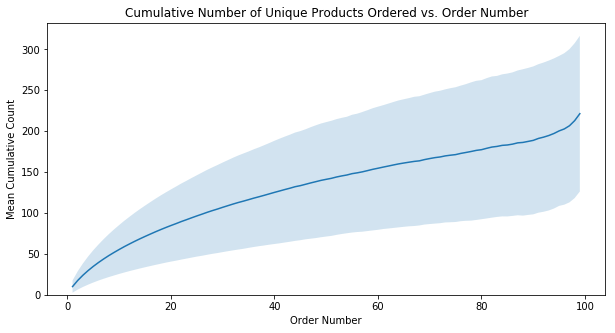

In [203]:
plot_data = data_prior.drop_duplicates(subset=['user_id', 'product_id']).groupby(['order_number','user_id'])['product_id'].count().unstack().cumsum().bfill()

mu = plot_data.mean(axis=1)
std = plot_data.std(axis=1)

plt.figure(figsize=(10,5))

ax = mu.plot()
ax.fill_between(std.keys(), mu - std.values, mu + std.values, alpha=0.2)

ax.set_ylim(bottom=0)
ax.set_title('Cumulative Number of Unique Products Ordered vs. Order Number')
ax.set_xlabel('Order Number')
ax.set_ylabel('Mean Cumulative Count')

plt.show()

It is important to note that in removing duplicates for the cumulative count approach above, values had to be backfilled so there is a certain amount of interpolation and smoothening which has introduced into this view. Regardless, the overall trend should remain true, which we can see shows a gradual decrease in the rate at which new products are ordered. There is an odd peak right at the end of this curve, but this is likely an artifact of the limited number of order data at the largest order numbers.

Moving on to distributions of orders over time of day/week, we can perform a few views utilizing violin plots to see if there are some noticeable variations in demand for different departments over the course of the week:

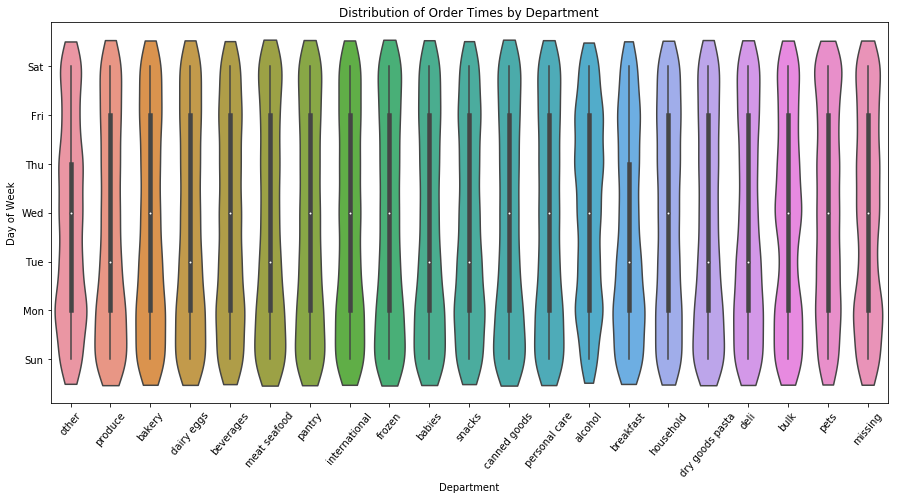

In [172]:
plt.figure(figsize=(15,7))
ax = sns.violinplot(data=data_prior.sample(int(1e5)), x='department', y='order_dow', cut=1, scale='area', bw=0.25)

ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_title('Distribution of Order Times by Department')
ax.set_xlabel('Department')
ax.set_ylabel('Day of Week')

ax.set_yticks(np.arange(0,7,1))
ax.set_yticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

plt.show()

We can notice a few variations in peaks between different departments and days of the week. We see the previously observed increases in demand on Sunday and Monday across most departments, and some departments have unique peaks such as "bulk" on Wednesday. However, overall this plot is bit difficult to discern between in terms of singling out strong variations so perhaps separating out our weekdays from weekends and analyzing demand by hour proves more useful:

In [7]:
# Assign binary value for weekend (1) or non-weekend (0)
data_prior['weekend'] = data_prior['order_dow'].apply(lambda x: int(x == 0 or x ==6))

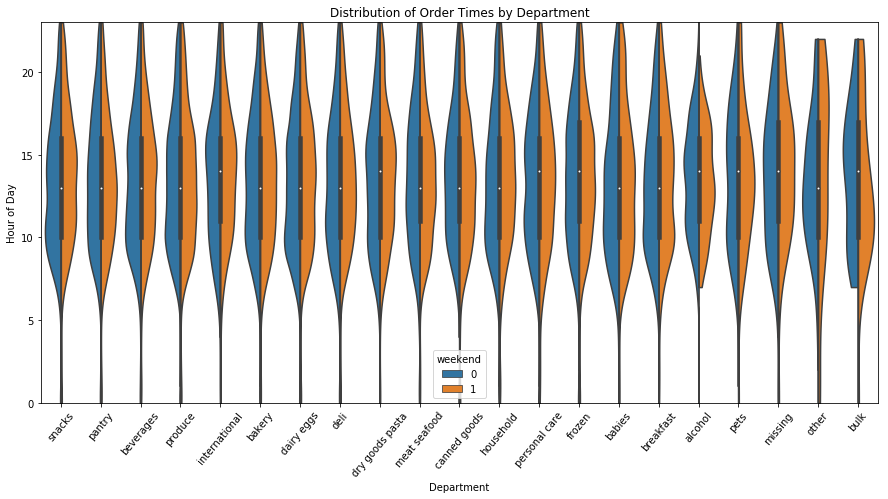

In [125]:
plt.figure(figsize=(15,7))
ax = sns.violinplot(data=data_prior.sample(int(1e5)), x='department', y='order_hour_of_day', cut=0, scale='area', hue='weekend', split=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_title('Distribution of Order Times by Department')
ax.set_xlabel('Department')
ax.set_ylabel('Hour of Day')
ax.set_ylim(0,23)

plt.show()

In [8]:
# Convert day of week and hour of day into a single hour of week value
data_prior['order_hour_of_week'] = data_prior[['order_dow', 'order_hour_of_day']].apply(lambda x: 24*x['order_dow'] + x['order_hour_of_day'], axis=1)

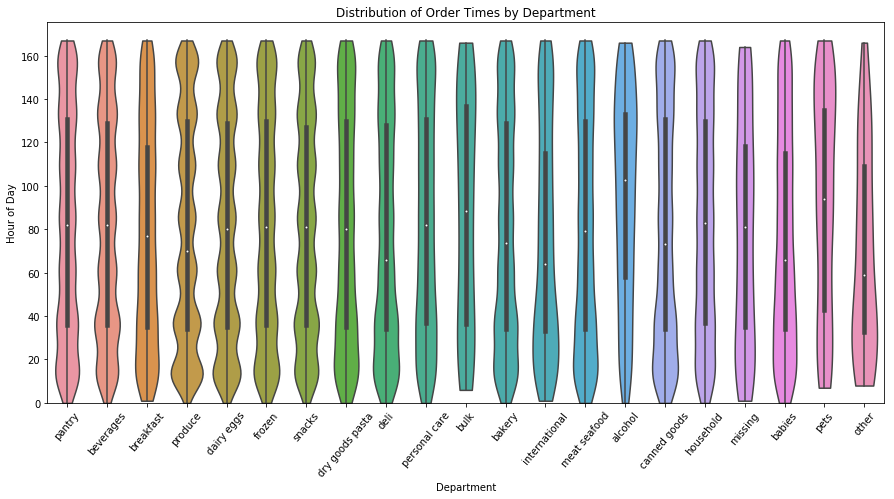

In [155]:
plt.figure(figsize=(15,7))
ax = sns.violinplot(data=data_prior.sample(int(1e5)), x='department', y='order_hour_of_week', cut=0, scale='area', split=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_title('Distribution of Order Times by Department')
ax.set_xlabel('Department')
ax.set_ylabel('Hour of Day')
ax.set_ylim(0)

plt.show()

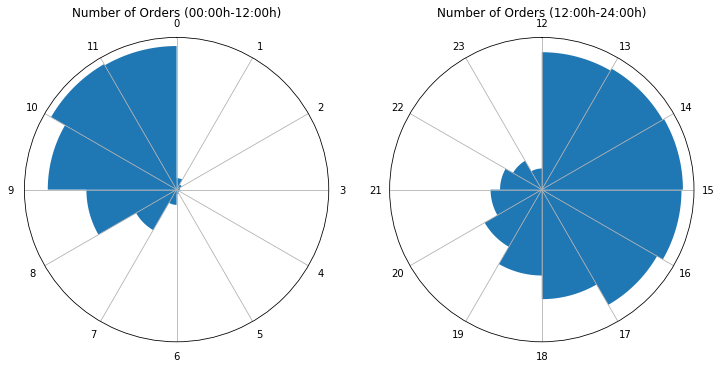

In [249]:
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection='polar'), figsize=(12,7))

n = 12
x = np.linspace(0,2*np.pi,12, endpoint=False)
y1 = data_prior['order_hour_of_day'].value_counts().sort_index()[:12]
y2 = data_prior['order_hour_of_day'].value_counts().sort_index()[12:]

ax1=axs.flatten()[0]
ax1.bar(x, y1, width=2*np.pi/n, align='edge')
ax1.set_title('Number of Orders (00:00h-12:00h)')

ax2=axs.flatten()[1]
ax2.bar(x, y2, width=2*np.pi/n, align='edge')
ax2.set_title('Number of Orders (12:00h-24:00h)')

for i, ax in enumerate(axs):
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')
    ax.set_yticklabels([])
    ax.set_xticks(x)
    ax.set_xticklabels((i*12) + np.arange(0,12,1))
    ax.set_ylim(0, max(ax1.get_ylim()[1], ax2.get_ylim()[1]))
    ax.yaxis.grid(False)

plt.show()

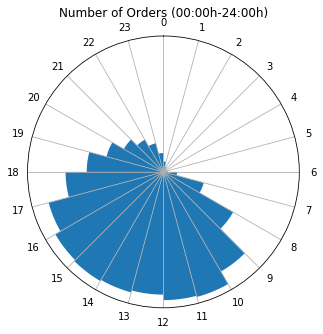

In [259]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize=(10,5))

n = 24
x = np.linspace(0,2*np.pi,n, endpoint=False)
y = data_prior['order_hour_of_day'].value_counts().sort_index()


ax.bar(x, y, width=2*np.pi/n, align='edge')
ax.set_title('Number of Orders (00:00h-24:00h)')

ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax.set_yticklabels([])
ax.set_xticks(x)
ax.set_xticklabels(np.arange(0,n,1))
ax.yaxis.grid(False)


plt.show()

In [9]:
cmap = plt.cm.RdYlGn
cmap_norm = matplotlib.colors.Normalize(vmin=-3, vmax=3)

In [26]:
c

array([[0.59684737, 0.82729719, 0.40976547, 1.        ],
       [0.64605921, 0.84882737, 0.41514802, 1.        ],
       [0.63621684, 0.84452134, 0.41407151, 1.        ],
       [0.62637447, 0.8402153 , 0.412995  , 1.        ],
       [0.65490196, 0.85267205, 0.41822376, 1.        ],
       [0.63621684, 0.84452134, 0.41407151, 1.        ],
       [0.68627451, 0.86620531, 0.43852364, 1.        ],
       [0.99853902, 0.95470973, 0.67304883, 1.        ],
       [0.99707805, 0.9987697 , 0.74502115, 1.        ],
       [0.74901961, 0.89327182, 0.47912341, 1.        ],
       [0.59684737, 0.82729719, 0.40976547, 1.        ],
       [0.81176471, 0.92033833, 0.51972318, 1.        ],
       [0.99546328, 0.84767397, 0.51926182, 1.        ],
       [0.99223376, 0.68619762, 0.38362168, 1.        ],
       [0.99361784, 0.75540177, 0.44175317, 1.        ],
       [0.99331027, 0.74002307, 0.42883506, 1.        ],
       [0.99577086, 0.86305267, 0.53217993, 1.        ],
       [0.99592464, 0.87074202,

In [28]:
((norm[d] - norm.mean(axis=1)) / norm.std(axis=1)).values

array([ 1.31767704,  1.20166557,  1.22536085,  1.2462366 ,  1.19061852,
        1.24208486,  1.09071868, -0.21595784,  0.00830007,  0.89812013,
        1.32802784,  0.70917421, -0.6921649 , -1.17400332, -0.96272582,
       -1.02753255, -0.64222315, -0.61558816, -0.70066273, -0.58989458,
       -0.40445197, -0.15826922,  0.04941561,  0.8514915 ])

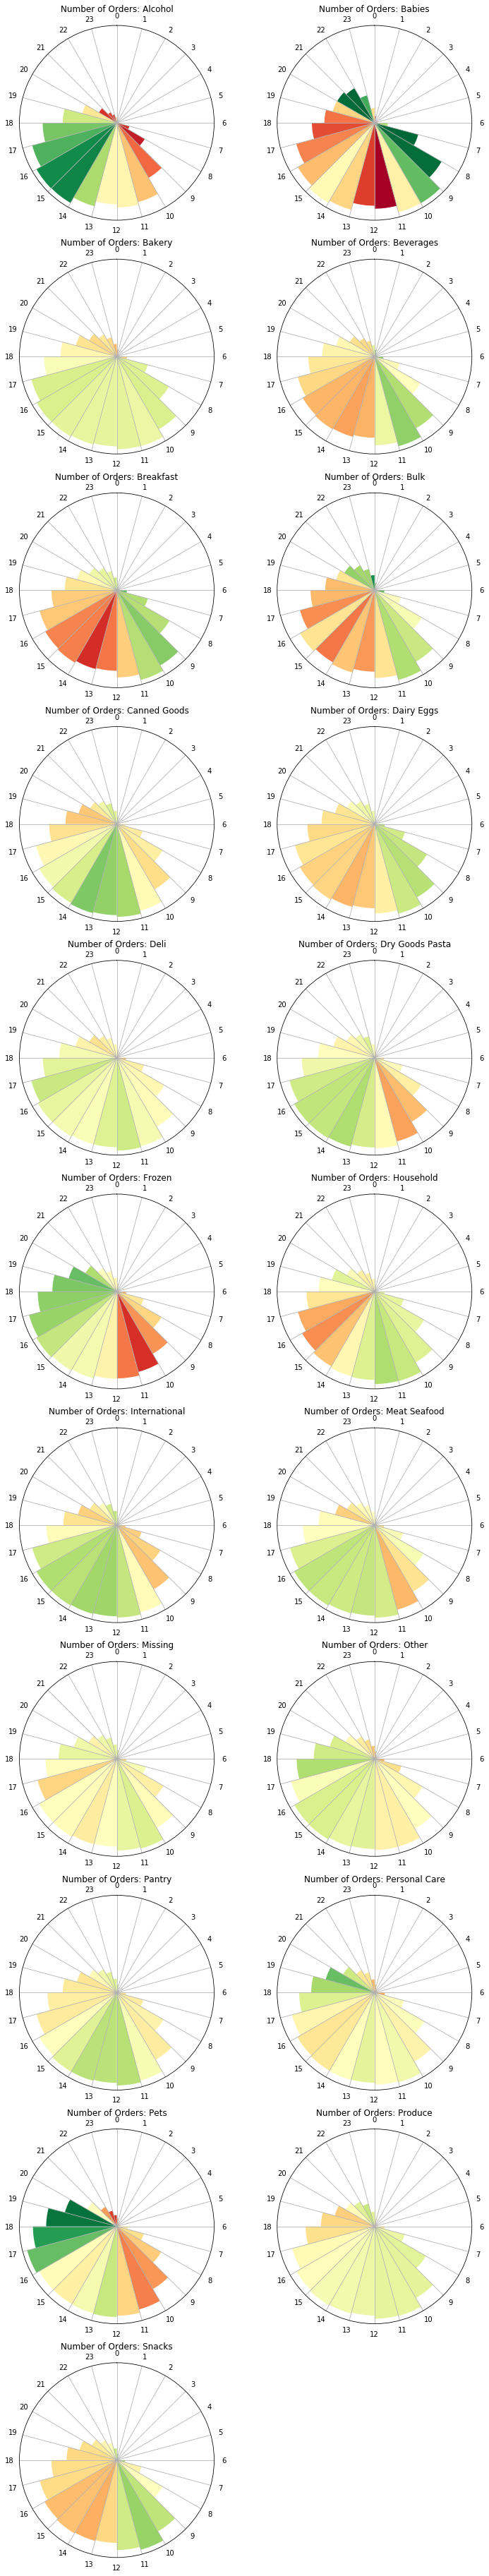

In [30]:
depts = data_prior['department'].unique()
depts.sort()
n_depts = len(depts)

n_rows = n_depts//2 + n_depts%2
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, subplot_kw=dict(projection='polar'), figsize=(6*n_cols,6*n_rows))

n = 24
x = np.linspace(0,2*np.pi,n, endpoint=False)
y_max = 0

norm = data_prior.groupby(['order_hour_of_day', 'department'])['order_id'].count().unstack()
norm = (norm - norm.mean()) / (norm.max() - norm.min())

for i, d in enumerate(depts):
    dept_mask = data_prior['department'] == d
    y = data_prior[dept_mask]['order_hour_of_day'].value_counts().sort_index()
    c = cmap(cmap_norm(((norm[d] - norm.mean(axis=1)) / norm.std(axis=1)).values))
    ax = axs.flatten()[i]
    bars = ax.bar(x, y, width=2*np.pi/n, align='edge', color=c)
    ax.set_title('Number of Orders: {}'.format(d.title()))

    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')
    ax.set_yticklabels([])
    ax.set_xticks(x)
    ax.set_xticklabels(np.arange(0,n,1))
    ax.yaxis.grid(False)

for ax in axs.flatten()[-(n_depts%2):]:
    ax.set_visible(False)
    
plt.show()

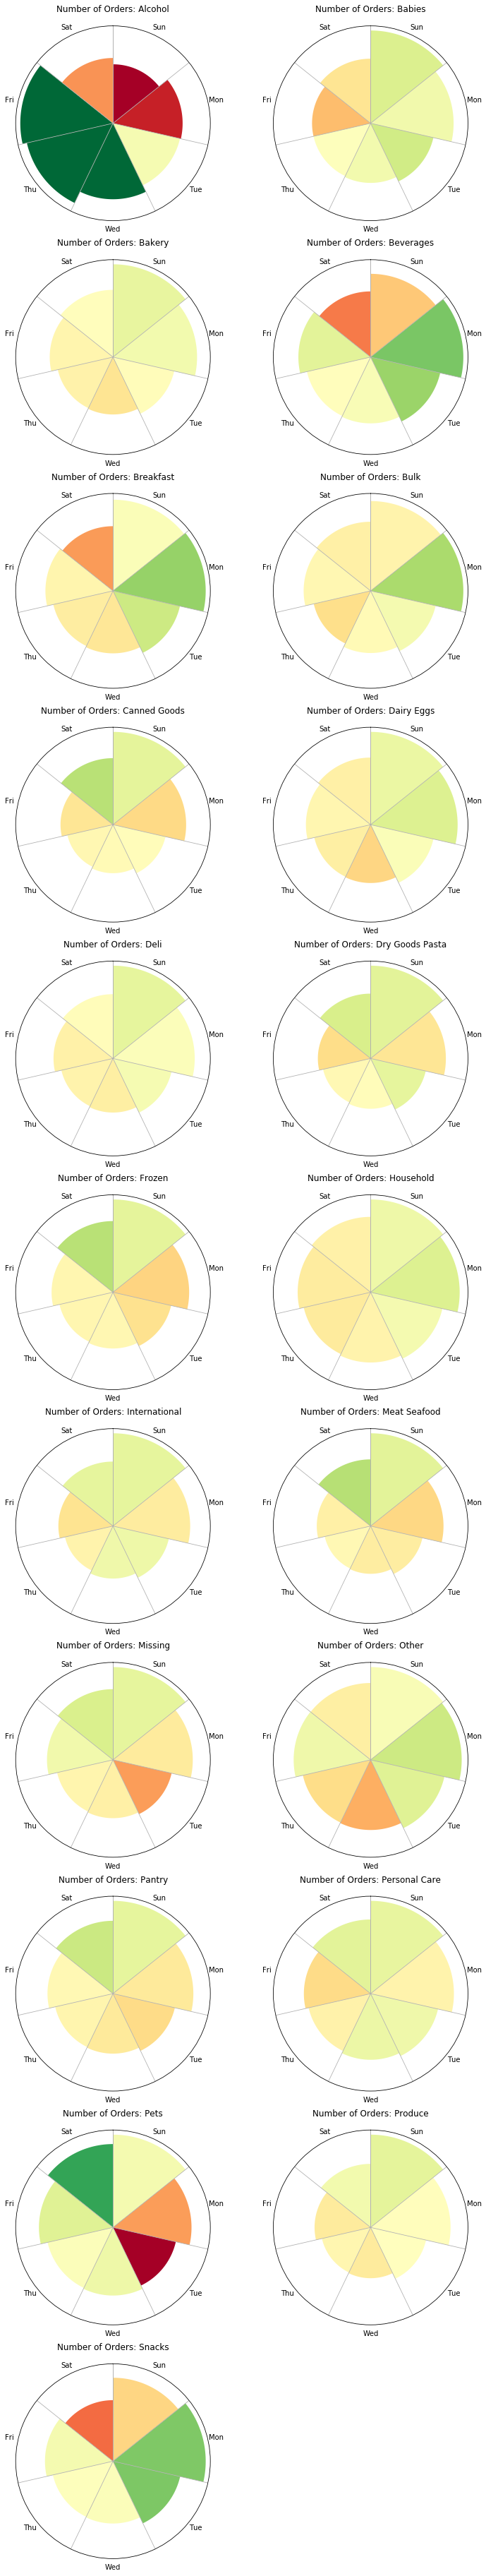

In [33]:
depts = data_prior['department'].unique()
depts.sort()
n_depts = len(depts)

n_rows = n_depts//2 + n_depts%2
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, subplot_kw=dict(projection='polar'), figsize=(6*n_cols,6*n_rows))

n = 7
x = np.linspace(0,2*np.pi,n, endpoint=False)
y_max = 0

norm = data_prior.groupby(['order_dow', 'department'])['order_id'].count().unstack()
norm = (norm - norm.mean()) / (norm.max() - norm.min())

for i, d in enumerate(depts):
    dept_mask = data_prior['department'] == d
    y = data_prior[dept_mask]['order_dow'].value_counts().sort_index()
    c = cmap(cmap_norm(((norm[d] - norm.mean(axis=1)) / norm.std(axis=1)).values))
    ax = axs.flatten()[i]
    bars = ax.bar(x, y, width=2*np.pi/n, align='edge', color=c)
    ax.set_title('Number of Orders: {}'.format(d.title()))

    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')
    ax.set_yticklabels([])
    ax.yaxis.grid(False)
    
    # Set the major and minor tick locations
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2*np.pi/n))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(np.pi/n))

    # Turn off major tick labels
    ax.xaxis.set_major_formatter(ticker.NullFormatter())

    # Set the minor tick width to 0 so you don't see them
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

    # Set the names of your ticks, with blank spaces for the major ticks
    ax.set_xticklabels(['','','Sun','','Mon','','Tue','','Wed','','Thu','','Fri','','Sat'],minor=True)
    ax.xaxis.grid(False, which='minor')

for ax in axs.flatten()[-(n_depts%2):]:
    ax.set_visible(False)
    
plt.show()

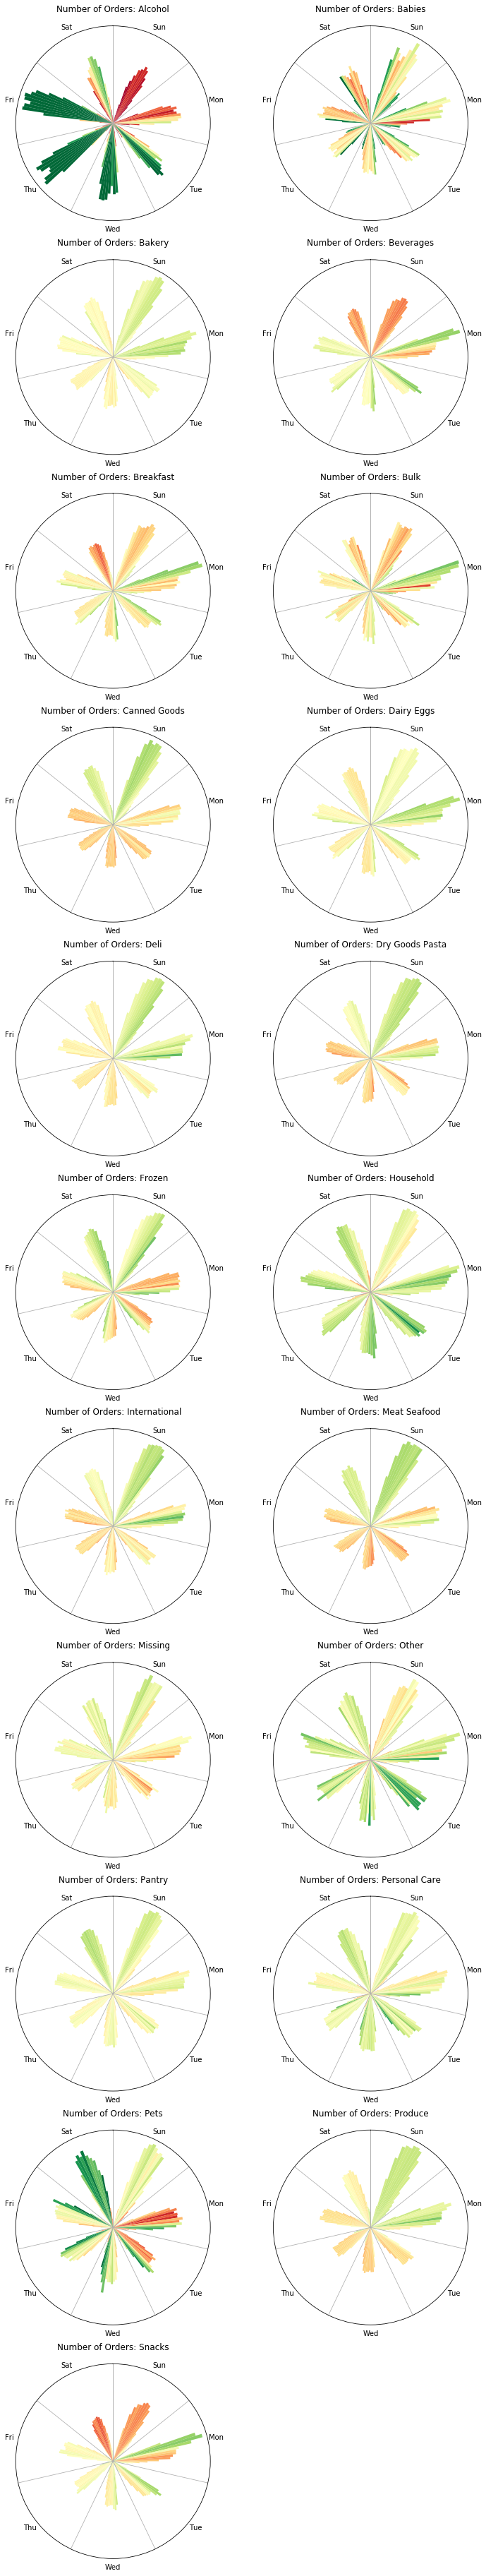

In [34]:
depts = data_prior['department'].unique()
depts.sort()
n_depts = len(depts)

n_rows = n_depts//2 + n_depts%2
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, subplot_kw=dict(projection='polar'), figsize=(6*n_cols,6*n_rows))

n = 24*7
x = np.linspace(0,2*np.pi,n, endpoint=False)
y_max = 0

norm = data_prior.groupby(['order_hour_of_week', 'department'])['order_id'].count().unstack()
norm = (norm - norm.mean()) / (norm.max() - norm.min())

for i, d in enumerate(depts):
    dept_mask = data_prior['department'] == d
    y = data_prior[dept_mask]['order_hour_of_week'].value_counts().sort_index()
    c = cmap(cmap_norm(((norm[d] - norm.mean(axis=1)) / norm.std(axis=1)).values))
    ax = axs.flatten()[i]
    bars = ax.bar(x, y, width=2*np.pi/n, align='edge', color=c)
    ax.set_title('Number of Orders: {}'.format(d.title()))

    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')
    ax.set_yticklabels([])
    ax.yaxis.grid(False)
    
    # Set the major and minor tick locations
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2*np.pi/7))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(np.pi/7))

    # Turn off major tick labels
    ax.xaxis.set_major_formatter(ticker.NullFormatter())

    # Set the minor tick width to 0 so you don't see them
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

    # Set the names of your ticks, with blank spaces for the major ticks
    ax.set_xticklabels(['','','Sun','','Mon','','Tue','','Wed','','Thu','','Fri','','Sat'],minor=True)
    ax.xaxis.grid(False, which='minor')
    
for ax in axs.flatten()[-(n_depts%2):]:
    ax.set_visible(False)
    
plt.show()